In [1]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
 
 
class myDataset(Dataset):
  def __init__(self, data_dir, segment_len=128):
    self.data_dir = data_dir
    self.segment_len = segment_len
 
    # Load the mapping from speaker neme to their corresponding id. 
    mapping_path = Path(data_dir) / "mapping.json"
    mapping = json.load(mapping_path.open())
    self.speaker2id = mapping["speaker2id"]
 
    # Load metadata of training data.
    metadata_path = Path(data_dir) / "metadata.json"
    metadata = json.load(open(metadata_path))["speakers"]
 
    # Get the total number of speaker.
    self.speaker_num = len(metadata.keys())
    self.data = []
    for speaker in metadata.keys():
      for utterances in metadata[speaker]:
        self.data.append([utterances["feature_path"], self.speaker2id[speaker]])
 
  def __len__(self):
    return len(self.data)
 
  def __getitem__(self, index):
    feat_path, speaker = self.data[index]
    # Load preprocessed mel-spectrogram.
    mel = torch.load(os.path.join(self.data_dir, feat_path))
 
    # Segmemt mel-spectrogram into "segment_len" frames.
    if len(mel) > self.segment_len:
      # Randomly get the starting point of the segment.
      start = random.randint(0, len(mel) - self.segment_len)
      # Get a segment with "segment_len" frames.
      mel = torch.FloatTensor(mel[start:start+self.segment_len])
    else:
      mel = torch.FloatTensor(mel)
    # Turn the speaker id into long for computing loss later.
    speaker = torch.FloatTensor([speaker]).long()
    return mel, speaker
 
  def get_speaker_number(self):
    return self.speaker_num

In [2]:
!pip3 install conformer

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
  # Process features within a batch.
  """Collate a batch of data."""
  mel, speaker = zip(*batch)
  # Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
  mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
  # mel: (batch size, length, 40)
  return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size, n_workers):
  """Generate dataloader"""
  dataset = myDataset(data_dir)
  speaker_num = dataset.get_speaker_number()
  # Split dataset into training dataset and validation dataset
  trainlen = int(0.9 * len(dataset))
  lengths = [trainlen, len(dataset) - trainlen]
  trainset, validset = random_split(dataset, lengths)

  train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
  )
  valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_batch,
  )

  return train_loader, valid_loader, speaker_num

In [4]:
#self attention pooling类实现
import torch.nn.functional as F
import torch.nn as nn
class Self_Attentive_Pooling(nn.Module):
   def __init__(self,dim):
       super(Self_Attentive_Pooling,self).__init__()
       self.sap_linear=nn.Linear(dim,dim)
       self.attention=nn.Parameter(torch.FloatTensor(dim,1))
       
   def forward(self,x):
       x=x.permute(0,2,1)
       h=torch.tanh(self.sap_linear(x))
       w=torch.matmul(h,self.attention).squeeze(dim=2)
       w=F.softmax(w,dim=1).view(x.size(0),x.size(1),1)
       x=torch.sum(x*w,dim=1)
       return x

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from conformer import ConformerBlock
class Classifier(nn.Module):
    def __init__(self, d_model=512, n_spks=600, dropout=0.1):
        super().__init__()
    # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(40, d_model)
    # TODO:
    #   Change Transformer to Conformer.
    #   https://arxiv.org/abs/2005.08100
        self.encoder_layer = nn.TransformerEncoderLayer(
          d_model=d_model, dim_feedforward=256, nhead=1
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

        self.block = ConformerBlock(
            dim = d_model,
            dim_head = 64,
            heads = 8,
            ff_mult = 4,
            conv_expansion_factor = 2,
            conv_kernel_size = 31,
            attn_dropout = dropout,
            ff_dropout = dropout,
            conv_dropout = dropout
        )

        self.pooling = Self_Attentive_Pooling(d_model)

        self.pred_layer = nn.Linear(d_model, n_spks)
        
    
    def forward(self, mels):
        """
        args:
          mels: (batch size, length, 40)
        return:
          out: (batch size, n_spks)
        """
        # out: (batch size, length, d_model)
        out = self.prenet(mels)
        # out: (length, batch size, d_model)
        out = out.permute(1, 0, 2)
        # The encoder layer expect features in the shape of (length, batch size, d_model).
        #out = self.encoder(out)
        out = self.block(out)
        # out: (batch size, length, d_model)
        #out = out.transpose(0, 1)
        out = out.permute(1,2,0)
        # mean pooling
        #stats = out.mean(dim=1)
        #stats = torch.median(out)
        stats = self.pooling(out)
        # out: (batch, n_spks)
        out = self.pred_layer(stats)
        return out


In [6]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR

    
def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
  """
  Create a schedule with a learning rate that decreases following the values of the cosine function between the
  initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
  initial lr set in the optimizer.

  Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule the learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

  Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
  """

  def lr_lambda(current_step):
    # Warmup
    if current_step < num_warmup_steps:
      return float(current_step) / float(max(1, num_warmup_steps))
    # decadence
    progress = float(current_step - num_warmup_steps) / float(
      max(1, num_training_steps - num_warmup_steps)
    )
    return max(
      0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
    )

  return LambdaLR(optimizer, lr_lambda, last_epoch)

In [7]:
import torch


def model_fn(batch, model, criterion, device):
  """Forward a batch through the model."""

  mels, labels = batch
  mels = mels.to(device)
  labels = labels.to(device)

  outs = model(mels)

  loss = criterion(outs, labels)

  # Get the speaker id with highest probability.
  preds = outs.argmax(1)
  # Compute accuracy.
  accuracy = torch.mean((preds == labels).float())

  return loss, accuracy


In [8]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device): 
  """Validate on validation set."""

  model.eval()
  running_loss = 0.0
  running_accuracy = 0.0
  pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

  for i, batch in enumerate(dataloader):
    with torch.no_grad():
      loss, accuracy = model_fn(batch, model, criterion, device)
      running_loss += loss.item()
      running_accuracy += accuracy.item()

    pbar.update(dataloader.batch_size)
    pbar.set_postfix(
      loss=f"{running_loss / (i+1):.2f}",
      accuracy=f"{running_accuracy / (i+1):.2f}",
    )

  pbar.close()
  model.train()

  return running_accuracy / len(dataloader)

In [9]:
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split

record = {'train_loss':[], 'val_acc': []}


def parse_args():
  """arguments"""
  config = {
    "data_dir": "../input/ml2021springhw43/Dataset/",
    "save_path": "model.ckpt",
    "batch_size": 32,
    "n_workers": 8,
    "valid_steps": 2000,
    "warmup_steps": 1000,
    "save_steps": 10000,
    "total_steps": 70000,
  }

  return config


def main(
  data_dir,
  save_path,
  batch_size,
  n_workers,
  valid_steps,
  warmup_steps,
  total_steps,
  save_steps,
):
  """Main function."""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"[Info]: Use {device} now!")

  train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
  train_iterator = iter(train_loader)                               #这里没有懂为什么要用iter(), train_loader本身就是一个iterator吧
  print(f"[Info]: Finish loading data!",flush = True)

  model = Classifier(n_spks=speaker_num).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=1e-3)
  scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
  print(f"[Info]: Finish creating model!",flush = True)                     # flush = True是什么意思

  best_accuracy = -1.0
  best_state_dict = None

  pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

  for step in range(total_steps):
    # Get data
    try:
      batch = next(train_iterator)
    except StopIteration:
      train_iterator = iter(train_loader)
      batch = next(train_iterator)

    loss, accuracy = model_fn(batch, model, criterion, device)
    batch_loss = loss.item()
    batch_accuracy = accuracy.item()
    record['train_loss'].append(batch_loss)

    # Updata model
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    # Log
    pbar.update()
    pbar.set_postfix(
      loss=f"{batch_loss:.2f}",
      accuracy=f"{batch_accuracy:.2f}",
      step=step + 1,
    )

    # Do validation
    if (step + 1) % valid_steps == 0:
      pbar.close()

      valid_accuracy = valid(valid_loader, model, criterion, device)
      record['val_acc'].append(valid_accuracy)

      # keep the best model
      if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_state_dict = model.state_dict()

      pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    # Save the best model so far.
    if (step + 1) % save_steps == 0 and best_state_dict is not None:
      torch.save(best_state_dict, save_path)
      pbar.write(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

  pbar.close()


if __name__ == "__main__":
  main(**parse_args())


[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!


Train: 100% 2000/2000 [01:46<00:00, 18.70 step/s, accuracy=0.31, loss=2.98, step=2000]
Valid: 100% 6944/6944 [00:08<00:00, 793.20 uttr/s, accuracy=0.32, loss=3.15] 
Train: 100% 2000/2000 [01:37<00:00, 20.56 step/s, accuracy=0.53, loss=1.89, step=4000]
Valid: 100% 6944/6944 [00:05<00:00, 1172.21 uttr/s, accuracy=0.46, loss=2.42]
Train: 100% 2000/2000 [01:37<00:00, 20.47 step/s, accuracy=0.62, loss=1.88, step=6000]
Valid: 100% 6944/6944 [00:06<00:00, 1054.47 uttr/s, accuracy=0.56, loss=1.95]
Train: 100% 2000/2000 [01:38<00:00, 20.28 step/s, accuracy=0.62, loss=1.29, step=8000]
Valid: 100% 6944/6944 [00:06<00:00, 1144.16 uttr/s, accuracy=0.59, loss=1.72]
Train: 100% 2000/2000 [01:38<00:00, 20.24 step/s, accuracy=0.66, loss=1.28, step=1e+4]
Valid: 100% 6944/6944 [00:05<00:00, 1190.55 uttr/s, accuracy=0.65, loss=1.48]
Train:   0% 3/2000 [00:00<02:46, 12.00 step/s, accuracy=0.72, loss=1.25, step=1e+4]

Step 10000, best model saved. (accuracy=0.6550)


Train: 100% 2000/2000 [01:38<00:00, 20.31 step/s, accuracy=0.75, loss=1.09, step=12000]
Valid: 100% 6944/6944 [00:04<00:00, 1431.81 uttr/s, accuracy=0.68, loss=1.37]
Train: 100% 2000/2000 [01:39<00:00, 20.18 step/s, accuracy=0.72, loss=1.23, step=14000]
Valid: 100% 6944/6944 [00:07<00:00, 951.31 uttr/s, accuracy=0.71, loss=1.25] 
Train: 100% 2000/2000 [01:38<00:00, 20.28 step/s, accuracy=0.84, loss=0.65, step=16000]
Valid: 100% 6944/6944 [00:04<00:00, 1448.91 uttr/s, accuracy=0.73, loss=1.14]
Train: 100% 2000/2000 [01:38<00:00, 20.37 step/s, accuracy=0.78, loss=1.03, step=18000]
Valid: 100% 6944/6944 [00:05<00:00, 1375.66 uttr/s, accuracy=0.74, loss=1.14]
Train: 100% 2000/2000 [01:40<00:00, 20.00 step/s, accuracy=0.84, loss=0.60, step=2e+4]
Valid: 100% 6944/6944 [00:04<00:00, 1449.04 uttr/s, accuracy=0.76, loss=1.04]
Train:   0% 4/2000 [00:00<02:28, 13.47 step/s, accuracy=0.75, loss=1.05, step=2e+4]

Step 20000, best model saved. (accuracy=0.7643)


Train: 100% 2000/2000 [01:38<00:00, 20.29 step/s, accuracy=0.84, loss=0.61, step=22000]
Valid: 100% 6944/6944 [00:05<00:00, 1386.11 uttr/s, accuracy=0.78, loss=0.93]
Train: 100% 2000/2000 [01:39<00:00, 20.20 step/s, accuracy=0.78, loss=0.61, step=24000]
Valid: 100% 6944/6944 [00:04<00:00, 1450.31 uttr/s, accuracy=0.77, loss=0.97]
Train: 100% 2000/2000 [01:38<00:00, 20.29 step/s, accuracy=0.91, loss=0.32, step=26000]
Valid: 100% 6944/6944 [00:04<00:00, 1442.95 uttr/s, accuracy=0.78, loss=0.95]
Train: 100% 2000/2000 [01:38<00:00, 20.27 step/s, accuracy=0.84, loss=0.37, step=28000]
Valid: 100% 6944/6944 [00:05<00:00, 1178.54 uttr/s, accuracy=0.80, loss=0.85]
Train: 100% 2000/2000 [01:37<00:00, 20.61 step/s, accuracy=0.75, loss=1.04, step=3e+4]
Valid: 100% 6944/6944 [00:04<00:00, 1426.33 uttr/s, accuracy=0.80, loss=0.85]
Train:   0% 4/2000 [00:00<02:26, 13.65 step/s, accuracy=0.94, loss=0.40, step=3e+4]

Step 30000, best model saved. (accuracy=0.8021)


Train: 100% 2000/2000 [01:39<00:00, 20.12 step/s, accuracy=0.94, loss=0.31, step=32000]
Valid: 100% 6944/6944 [00:04<00:00, 1400.23 uttr/s, accuracy=0.81, loss=0.82]
Train: 100% 2000/2000 [01:39<00:00, 20.02 step/s, accuracy=0.81, loss=0.60, step=34000]
Valid: 100% 6944/6944 [00:05<00:00, 1356.79 uttr/s, accuracy=0.83, loss=0.79]
Train: 100% 2000/2000 [01:37<00:00, 20.51 step/s, accuracy=0.91, loss=0.32, step=36000]
Valid: 100% 6944/6944 [00:07<00:00, 981.36 uttr/s, accuracy=0.83, loss=0.74] 
Train: 100% 2000/2000 [01:38<00:00, 20.21 step/s, accuracy=0.94, loss=0.23, step=38000]
Valid: 100% 6944/6944 [00:04<00:00, 1460.80 uttr/s, accuracy=0.83, loss=0.74]
Train: 100% 2000/2000 [01:40<00:00, 19.91 step/s, accuracy=0.91, loss=0.30, step=4e+4]
Valid: 100% 6944/6944 [00:05<00:00, 1252.38 uttr/s, accuracy=0.85, loss=0.67]
Train:   0% 4/2000 [00:00<02:24, 13.84 step/s, accuracy=0.94, loss=0.27, step=4e+4]

Step 40000, best model saved. (accuracy=0.8501)


Train: 100% 2000/2000 [01:40<00:00, 19.82 step/s, accuracy=0.91, loss=0.41, step=42000]
Valid: 100% 6944/6944 [00:04<00:00, 1450.25 uttr/s, accuracy=0.85, loss=0.68]
Train: 100% 2000/2000 [01:36<00:00, 20.66 step/s, accuracy=0.94, loss=0.28, step=44000]
Valid: 100% 6944/6944 [00:04<00:00, 1390.77 uttr/s, accuracy=0.85, loss=0.66]
Train: 100% 2000/2000 [01:40<00:00, 19.99 step/s, accuracy=1.00, loss=0.04, step=46000]
Valid: 100% 6944/6944 [00:04<00:00, 1457.14 uttr/s, accuracy=0.86, loss=0.63]
Train: 100% 2000/2000 [01:36<00:00, 20.65 step/s, accuracy=1.00, loss=0.04, step=48000]
Valid: 100% 6944/6944 [00:04<00:00, 1446.49 uttr/s, accuracy=0.87, loss=0.63]
Train: 100% 2000/2000 [01:39<00:00, 20.14 step/s, accuracy=1.00, loss=0.02, step=5e+4]
Valid: 100% 6944/6944 [00:07<00:00, 985.62 uttr/s, accuracy=0.87, loss=0.57] 
Train:   0% 3/2000 [00:00<03:22,  9.85 step/s, accuracy=0.97, loss=0.10, step=5e+4]

Step 50000, best model saved. (accuracy=0.8705)


Train: 100% 2000/2000 [01:37<00:00, 20.45 step/s, accuracy=1.00, loss=0.02, step=52000]
Valid: 100% 6944/6944 [00:04<00:00, 1458.11 uttr/s, accuracy=0.87, loss=0.59]
Train: 100% 2000/2000 [01:37<00:00, 20.60 step/s, accuracy=0.97, loss=0.10, step=54000]
Valid: 100% 6944/6944 [00:05<00:00, 1371.61 uttr/s, accuracy=0.87, loss=0.57]
Train: 100% 2000/2000 [01:41<00:00, 19.71 step/s, accuracy=0.91, loss=0.30, step=56000]
Valid: 100% 6944/6944 [00:05<00:00, 1387.57 uttr/s, accuracy=0.88, loss=0.53]
Train: 100% 2000/2000 [01:36<00:00, 20.65 step/s, accuracy=1.00, loss=0.03, step=58000]
Valid: 100% 6944/6944 [00:05<00:00, 1387.28 uttr/s, accuracy=0.88, loss=0.53]
Train: 100% 2000/2000 [01:36<00:00, 20.65 step/s, accuracy=1.00, loss=0.05, step=6e+4]
Valid: 100% 6944/6944 [00:05<00:00, 1383.51 uttr/s, accuracy=0.89, loss=0.52]
Train:   0% 4/2000 [00:00<02:27, 13.57 step/s, accuracy=1.00, loss=0.06, step=6e+4]

Step 60000, best model saved. (accuracy=0.8852)


Train: 100% 2000/2000 [01:41<00:00, 19.61 step/s, accuracy=1.00, loss=0.08, step=62000]
Valid: 100% 6944/6944 [00:04<00:00, 1394.91 uttr/s, accuracy=0.88, loss=0.52]
Train: 100% 2000/2000 [01:36<00:00, 20.70 step/s, accuracy=0.91, loss=0.31, step=64000]
Valid: 100% 6944/6944 [00:05<00:00, 1385.89 uttr/s, accuracy=0.89, loss=0.52]
Train: 100% 2000/2000 [01:39<00:00, 20.15 step/s, accuracy=0.97, loss=0.06, step=66000]
Valid: 100% 6944/6944 [00:06<00:00, 1021.62 uttr/s, accuracy=0.89, loss=0.53]
Train: 100% 2000/2000 [01:39<00:00, 20.05 step/s, accuracy=1.00, loss=0.05, step=68000]
Valid: 100% 6944/6944 [00:04<00:00, 1457.49 uttr/s, accuracy=0.89, loss=0.51]
Train: 100% 2000/2000 [01:36<00:00, 20.65 step/s, accuracy=0.94, loss=0.23, step=7e+4]
Valid: 100% 6944/6944 [00:04<00:00, 1450.10 uttr/s, accuracy=0.89, loss=0.50]
Train:   0% 0/2000 [00:00<?, ? step/s]


Step 70000, best model saved. (accuracy=0.8921)


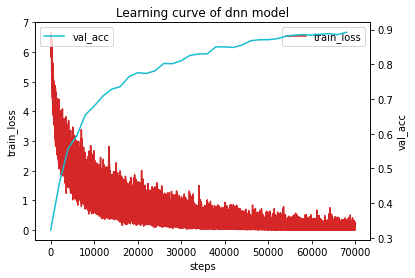

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
config = parse_args()
x1 = np.arange(config['total_steps'])
x2 = x1[::config['valid_steps']]
y1 = record['train_loss']
y2 = record['val_acc']
fig = figure(figsize = (6,4))
ax1 = fig.add_subplot(111)
ax1.plot(x1,y1, c = 'tab:red', label = 'train_loss')
ax2 = ax1.twinx()
ax2.plot(x2,y2, c='tab:cyan', label='val_acc')
ax1.set_xlabel('steps')
ax1.set_ylabel('train_loss')
ax2.set_ylabel('val_acc')
plt.title('Learning curve of dnn model')
ax1.legend()
ax2.legend()
plt.show()

## import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

def parse_args():
  """arguments"""
  config = {
    "data_dir": "../input/ml2021springhw43/Dataset/",
    "model_path": "./model.ckpt",
    "output_path": "./output.csv",
  }

  return config


def main(
  data_dir,
  model_path,
  output_path,
):
  """Main function."""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"[Info]: Use {device} now!")

  mapping_path = Path("../input/ml2021springhw43/Dataset/mapping.json")
  mapping = json.load(mapping_path.open())

  dataset = InferenceDataset(data_dir)
  dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    collate_fn=inference_collate_batch,
  )
  print(f"[Info]: Finish loading data!",flush = True)

  speaker_num = len(mapping["id2speaker"])
  model = Classifier(n_spks=speaker_num).to(device)
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"[Info]: Finish creating model!",flush = True)

  results = [["Id", "Category"]]
  for feat_paths, mels in tqdm(dataloader):
    with torch.no_grad():
      mels = mels.to(device)
      outs = model(mels)
      preds = outs.argmax(1).cpu().numpy()
      for feat_path, pred in zip(feat_paths, preds):
        results.append([feat_path, mapping["id2speaker"][str(pred)]])
  
  with open(output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(results)


if __name__ == "__main__":
  main(**parse_args())